# LIBRARIES

In [1]:
import pickle
from Environment import Environment
from UserCat import UserCat
from Product import Product
from Greedy_optimizer import *
import numpy as np
import matplotlib.pyplot as plt
from ucb1_brute_force import *
from ucb1_greedy import *

# ENVIRONMENT DEFINITION 

In [2]:
np.random.seed(1)

users = []
products=[]

nameofproduct= [ #name of products
    "Calabazas",
    "Hinojo",
    "Sesamo",
    "Girasol",
    "Amapola"
]

prices=[[5., 6, 7, 8],
    [13., 16, 19, 22],
    [20., 24, 27, 31],
    [30., 33, 37, 41],
    [40., 44, 48, 52]]
#1-2 di delta, Con sovrapposizione

cost=[1.3, 1.8, 2.1, 2.7 ,5]

#sarebbe interessante anche prendere da file il tutto così da cambiare tutto più facilmente
#calcolo i margini dai cost mi sembra più sensato e anche più veloce se dobbiamo cambiare continuamente

cost2 = np.tile(np.array([cost]).transpose(), (1, 4))
margins = np.array(prices)-cost2

Secondary_dict={           # Propongo i prodotti più simili a quello mostrato --> problemino: 2 viene mostrato quasi sempre
    "Calabazas": [1,2],
    "Hinojo": [0,2],
    "Sesamo": [1,3],
    "Girasol": [2,4],
    "Amapola": [2,3]
}

#Secondary_dict={           # Propongo i prodotti più simili a quello mostrato --> problemino: 2 viene mostrato quasi sempre
#    "Calabazas": [1,4],
#    "Hinojo": [2,0],
#    "Sesamo": [0,3],
#    "Girasol": [4,1],
#    "Amapola": [3,2]
#}

res_price_params = {
    "shape": 8,  # media è shape*scale, la varianza è shape*scale^2
    "scale": 3
}


probabilities = [[0, 0.6, 0.3, 0, 0],
                 [0.4, 0, 0.5, 0, 0],
                 [0, 0.5, 0, 0.5, 0],
                 [0, 0, 0.6, 0, 0.5],
                 [0, 0, 0.3, 0.5, 0]]
probabilities = np.matrix(probabilities)


alphas=[10, 10, 10, 10, 10] 
# per ora li generiamo così, tutti uguali -> devo generare 3 diversi vettori alpha

poisson_lambda = 3
#=valore atteso del numero di prodotti acquistati (specifico per prodotto)...non dipende dal
#prodotto oltre che dallo user che dal tipo di user che

# p_users = [4/9, 3/9, 2/9] #probabilità di essere un tipo di utente-> da cambiare
p_users = [1]

lambda_q = 0.7 #just my idea of lambda
#possiamo stimarlo con i dati passati provenienti dal sito -> vino tot è stato comprato 15 volte

#proviamo a pensare, ha senso vederlo come coppia? categoria-prodotto? Avrei 3 categorie *5 prodotti-> 15 lambda diversi
# ^^ Andre: secondo me ha senso avere 3 lambda_q diversi per categoria MA non per prodotto. La probabilità di continuare
#           a guardare secondo me dipende dall'utente e non dal prodotto

for i in range (5):
    products.append(Product(prices[i], i, nameofproduct[i],margins[i]))

# for i in range(3):
users.append(UserCat(alphas, res_price_params, poisson_lambda, probabilities))

Env = Environment(users, products,  lambda_q, Secondary_dict, p_users)

In [3]:
Env.optimal_reward()

(51.664091043657685, [3, 1, 0, 0, 0])

In [4]:
a = Env.simulate_day(2000, [0,0,0,0,0], ["conversion_rates", "alpha_ratios", "products_sold", "graph_weights"])
a

{'CR_vector': array([[697., 693., 420., 118.,  41.],
        [697., 746., 635., 410., 655.]]),
 'alpha_ratios': array([0.2805, 0.14  , 0.144 , 0.126 , 0.3095]),
 'n_prod_sold': array([3.98703032, 3.96386777, 3.926097  , 3.92339632, 4.12094611]),
 'graph_weights': array([[0.        , 0.6203098 , 0.2080254 , 0.        , 0.        ],
        [0.37464533, 0.        , 0.34357426, 0.        , 0.        ],
        [0.        , 0.47198112, 0.        , 0.39275471, 0.        ],
        [0.        , 0.        , 0.57884582, 0.        , 0.33641716],
        [0.        , 0.        , 0.32247662, 0.24989588, 0.        ]])}

In [5]:
np.matrix(Env.theoretical_values["conversion_rates"][0])

matrix([[0.99965933, 0.99890328, 0.99717758, 0.99383156],
        [0.92650349, 0.82957795, 0.69695583, 0.5491743 ],
        [0.64824714, 0.45296081, 0.32389696, 0.19168223],
        [0.22022065, 0.14319153, 0.07592134, 0.0379236 ],
        [0.04534008, 0.02178297, 0.00999978, 0.00441321]])

# Greedy Algorithm Example

In [7]:
greedy_optimizer = Greedy_optimizer(Env)
greedy_optimizer.run()

{'combination': [3, 1, 0, 0, 0], 'expected_reward': 51.664091043657685}

# STEP 3 : Uncertain Convertion Rates

In [8]:
from step3_learner import TS_learner3

In [9]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
a = np.ones((5,4))
b = np.ones((5,4))
initial_beta = [a, b]
learner = TS_learner3(initial_beta, Env, learning_rate = 0.1)

In [11]:
n_runs = 5
daily_users = 200
n_days = 300

# delete possible old reward_history
learner.reward_history = []

learner.run(n_days, daily_users)

for i in range(n_runs) :
    learner.run(n_days, daily_users)

opt_reward = learner.opt_reward
collected_rewards = learner.reward_history

- ## Salvo la history su file in modo che siamo sicuri ti riuscire a recuperarla anche in un secondo momento

In [ ]:
with open('step3_rewards', 'wb') as f: 
    pickle.dump(collected_rewards, f)

- ## Per recuperare, invece, i risultati ottenuti in un secondo momento :

In [13]:
with open('step3_rewards', 'rb') as f: 
    collected_rewards = pickle.load(f)

- ## Cumulative Regret Plot

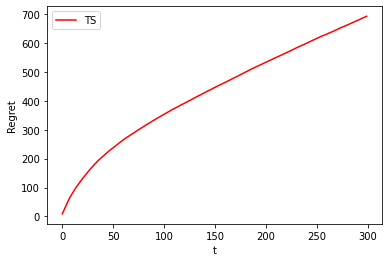

In [25]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt_reward - collected_rewards, axis=0)), 'r')  #'r' stay for red, the color for the TS algorithm
#plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)), 'g') #'g' stay for green, the color for the Greedy algorithm
plt.legend(["TS"])
plt.show()

- ## Standard Deviation Plot

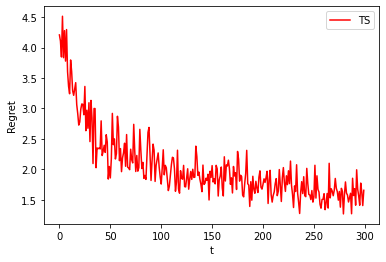

In [26]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.std(opt_reward - collected_rewards, axis=0), 'r')  #'r' stay for red, the color for the TS algorithm
#plt.plot(np.std(opt - gr_rewards_per_experiment, axis=0), 'g')  #'g' stay for green, the color for the Greedy algorithm
plt.legend(["TS"])
plt.show()

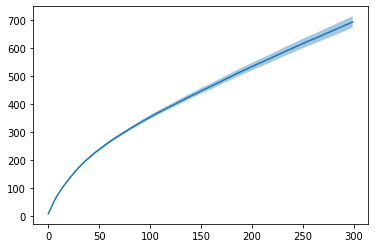

In [27]:
# mean_R = np.mean(R, axis=0)
cum_R = np.cumsum(opt_reward - collected_rewards, axis = 1)
mean_cum_R = np.mean(cum_R, axis = 0)
std_dev = np.std(cum_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R)
plt.fill_between(range(n_days), mean_cum_R-std_dev, mean_cum_R+std_dev, alpha=0.4)

- ## Comparison between Optimal and Expected Reward

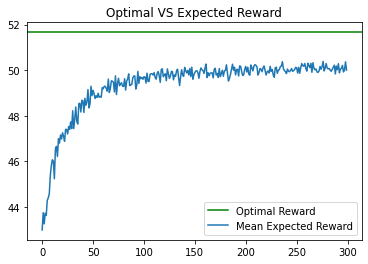

In [28]:
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

## Explore the istant regret in the collected runs of the step 3 learner

In [20]:
opt_reward = learner.opt_reward
(opt_reward - collected_rewards)[2][-40:]

array([0.15688612, 0.15688612, 0.15688612, 0.15688612, 0.15688612,
       0.8549016 , 0.15688612, 0.15688612, 0.15688612, 0.15688612,
       0.15688612, 0.15688612, 0.15688612, 0.15688612, 0.15688612,
       0.15688612, 0.15688612, 0.15688612, 0.15688612, 0.15688612,
       0.15688612, 0.15688612, 0.15688612, 0.15688612, 0.15688612,
       0.15688612, 0.15688612, 0.15688612, 0.15688612, 0.15688612,
       0.15688612, 0.15688612, 0.15688612, 0.15688612, 0.15688612,
       0.15688612, 0.15688612, 0.15688612, 0.15688612, 0.15688612])

## Comparison between mean conversion rates estimated by last run of TS and real values

In [29]:
A = learner.beta_parameters[0]
B = learner.beta_parameters[1]
mean_cr = A/(A+B)
mean_cr

array([[0.99100719, 0.97493734, 0.99313409, 0.99572933],
       [0.94944913, 0.86904936, 0.76748789, 0.58468677],
       [0.73010518, 0.55250515, 0.40217391, 0.5       ],
       [0.26326221, 0.17962836, 0.17006803, 0.09333333],
       [0.06706733, 0.03884796, 0.03551913, 0.10869565]])

In [30]:
np.matrix(Env.theoretical_values['conversion_rates'][0])

matrix([[0.99965933, 0.99890328, 0.99717758, 0.99383156],
        [0.92650349, 0.82957795, 0.69695583, 0.5491743 ],
        [0.64824714, 0.45296081, 0.32389696, 0.19168223],
        [0.22022065, 0.14319153, 0.07592134, 0.0379236 ],
        [0.04534008, 0.02178297, 0.00999978, 0.00441321]])

In [31]:
Env.optimal_reward()

(51.664091043657685, [3, 1, 0, 0, 0])

- ### ucb1 (with greedy optimizer)

In [ ]:
ucb1_greedy_R = []
ucb1g_collected_rewards = []
for _ in range(n_runs):
    ucb_greedy = ucb1_greedy(len(prices), len(prices[0]), prices, Env)
    instant_regret = []
    ucb1g_collected_rewards_temp = []
    for t in range(n_days):
        pulled_arms = ucb_greedy.pull_arms()
        estimated_CR = Env.simulate_day(daily_users, pulled_arms, ["conversion_rates"])['CR_vector']
        ucb_greedy.update(pulled_arms, estimated_CR)
        reward = Env.expected_reward(pulled_arms)
        ucb1g_collected_rewards_temp.append(reward)
        instant_regret.append(opt_reward - reward)
    ucb1g_collected_rewards.append(ucb1g_collected_rewards_temp)
    cumulative_regret = np.cumsum(instant_regret)
    ucb1_greedy_R.append(cumulative_regret)

In [ ]:
# store the result
with open("ucb1_greedy_R", 'wb') as f1:
    pickle.dump(ucb1_greedy_R, f1)
with open("ucb1g_collected_rewards", 'wb') as f1:
    pickle.dump(ucb1g_collected_rewards, f1)

In [24]:
# load the result
with open("ucb1_greedy_R", 'rb') as f1:
    ucb1_greedy_R = pickle.load(f1)
with open("ucb1g_collected_rewards", 'rb') as f1:
    ucb1g_collected_rewards = pickle.load(f1)

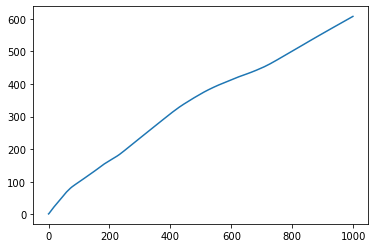

In [25]:
# plot of the result
mean_ucbg_R = np.mean(ucb1_greedy_R, axis=0)
std_dev_ucbg = np.std(ucb1_greedy_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_ucbg_R)
plt.fill_between(range(n_days), mean_ucbg_R-std_dev_ucbg, mean_ucbg_R+std_dev_ucbg, alpha=0.4)

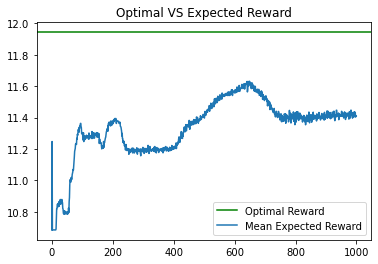

In [26]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(ucb1g_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

- ### ucb1 (brute force approach)

In [ ]:
n_runs = 2

ucb1_bforce_R = []
ucb1bf_collected_rewards = []
for _ in range(n_runs):
    ucb_brute_force = ucb1_brute_force(len(prices), len(prices[0]), prices, Env)
    instant_regret = []
    ucb1bf_collected_rewards_temp = []
    for t in range(n_days):
        pulled_arms = ucb_brute_force.pull_arms()
        estimated_CR = Env.simulate_day(daily_users, pulled_arms, ["conversion_rates"])['CR_vector']
        ucb_brute_force.update(pulled_arms, estimated_CR)
        reward = Env.expected_reward(pulled_arms)
        ucb1bf_collected_rewards_temp.append(reward)
        instant_regret.append(opt_reward - reward)
    ucb1bf_collected_rewards.append(ucb1bf_collected_rewards_temp)
    cumulative_regret = np.cumsum(instant_regret)
    ucb1_bforce_R.append(cumulative_regret)

In [ ]:
# store the result
with open("ucb1_bforce_R", 'wb') as f1:
    pickle.dump(ucb1_bforce_R, f1)
with open("ucb1bf_collected_rewards", 'wb') as f1:
    pickle.dump(ucb1bf_collected_rewards, f1)

In [27]:
# load the result
with open("ucb1_bforce_R", 'rb') as f1:
    ucb1_bforce_R = pickle.load(f1)
with open("ucb1bf_collected_rewards", 'rb') as f1:
    ucb1bf_collected_rewards = pickle.load(f1)

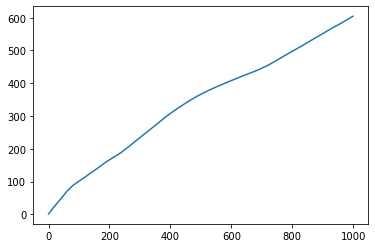

In [28]:
# plot of the result
mean_ucbbf_R = np.mean(ucb1_bforce_R, axis=0)
std_dev_ucbbf = np.std(ucb1_bforce_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_ucbbf_R)
plt.fill_between(range(n_days), mean_ucbbf_R-std_dev_ucbbf, mean_ucbbf_R+std_dev_ucbbf, alpha=0.4)

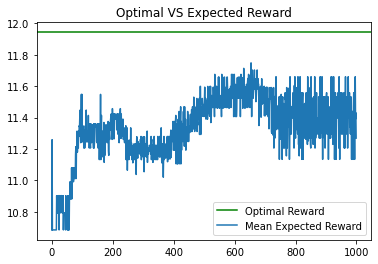

In [29]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(ucb1bf_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()